#### Example of text classification with embedding layer, max pooling and MLP network.

Reference pages:
- https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn
- https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [1]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
print(df.isnull().sum())
df.head()

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",My XXXX XXXX Account Was Paid Off But They Hav...,0
1,1,"Credit reporting, credit repair services, or o...",I had a citibank checking account which I clos...,0
2,2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,0
3,3,"Credit reporting, credit repair services, or o...",Account from XXXX with a balance is reporting ...,0
4,4,"Credit reporting, credit repair services, or o...",The credit bureaus are reporting inaccurate/ou...,0


Text preprocessing

In [2]:
%%time
import re
from nltk.corpus import stopwords

text = df.Consumer_complaint_narrative

# removing XXX words
text = text.apply(lambda x: re.sub(r'X*', '', x))

# converting to lower case
text = text.apply(lambda x: x.lower())

# replacing symbols with spaces
text = text.apply(lambda x: re.sub(r'[/(){}\[\]\|@,;]', ' ', x))

# removing bad symbols
text = text.apply(lambda x: re.sub(r'[^0-9a-z #+_]', '', x))

# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# removing stop words
STOPWORDS = set(stopwords.words('english'))
text = text.apply(lambda x: ' '.join(word for word in x.split() if word not in STOPWORDS))

CPU times: user 2.76 s, sys: 108 ms, total: 2.87 s
Wall time: 2.88 s


In [3]:
def print_example(index):
    print("-"*50)
    print("* BEFORE: {}".format(df.Consumer_complaint_narrative[index]))
    print("\n* AFTER: {}\n".format(text[index]))
    
print_example(0)
print_example(10)
print_example(50)

--------------------------------------------------
* BEFORE: My XXXX XXXX Account Was Paid Off But They Have Left The Wrong Information On My Credit Report For 11 Years The Account Should Be Removed It Is Too OldAnd A Medical Account That I Believed To Be Payed Off Has Also Been Left On My Report

* AFTER: account paid left wrong information credit report years account removed oldand medical account believed payed also left report

--------------------------------------------------
* BEFORE: Please be advised this is my THIRD WRITTEN REQUEST and FINAL WARNING that I fully intend to pursue litigation in accordance with the FCRA to enforce my rights and seek relief and recover all monetary damages that I may be entitled to under Section 616 and Section 617 regarding your continued willful and negligent noncompliance.

Despite two written requests, the unverified items listed below still remain on my credit report in violation of Federal Law. You are required under the FCRA to have a copy

Creating train and test sets, with balanced frequency of classes.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encoding labels to one hot vectors
encoder = LabelEncoder()
encoder.fit(df['category_id'])
encoded_Y = encoder.transform(df['category_id'])
Y = np_utils.to_categorical(encoded_Y)

sss = StratifiedShuffleSplit(n_splits=1, 
                             test_size=0.3, 
                             random_state=0)
for train_index, test_index in sss.split(text, Y):
    train_sentences = text.loc[train_index]
    Y_train = Y[train_index]
    test_sentences = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]
    Y_test = Y[test_index]

Using TensorFlow backend.


**Preparing the input**

The `Tokenizer` utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. We can add the parameter `num_words`, which is responsible for setting the size of the vocabulary. The most common `num_words` words will be then kept.

In [5]:
%%time
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

X_train = tokenizer.texts_to_sequences(train_sentences)
X_test = tokenizer.texts_to_sequences(test_sentences)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

CPU times: user 511 ms, sys: 0 ns, total: 511 ms
Wall time: 515 ms


The indexing is ordered after the most common words in the text. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which will be done in a moment.

Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information. You can see the index of each word by taking a look at the `word_index` dictionary of the `Tokenizer` object.

In [6]:
def print_word_index_pair(index):
    print('{}: {}'.format(tokenizer.index_word[index], index))

print_word_index_pair(45)
print_word_index_pair(111)
print_word_index_pair(1)

asked: 45
proof: 111
account: 1


With Tokenizer, the resulting vectors will have the length of each document, and the resulting vectors won't have the same length. To counter this, you can use `pad_sequence()` which simply pads the sequence of words with zeros. By default, it prepends zeros but we will to append them. Additionally you would want to add a `maxlen` parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

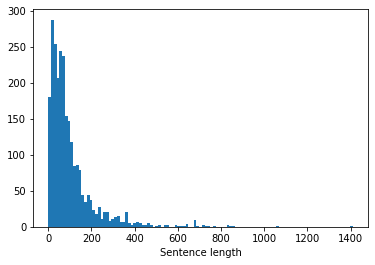

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# analyzing the sentences' length
freqs = pd.Series(X_train).apply(lambda x: len(x))
plt.hist(freqs, bins='auto') 
plt.xlabel('Sentence length');

In [8]:
from keras.preprocessing.sequence import pad_sequences

max_len = 450

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

**Creating and traning the model**

We can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. We will use the following parameters:

- `input_dim`: the size of the vocabulary
- `output_dim`: the size of the dense vector
- `input_length`: the length of the sequence

After the embedding layer, we will apply a MaxPooling1D/AveragePooling1D or a pooling layer (`GlobalMaxPooling1D` or `GlobalAveragePooling1D`).

In the case of max pooling, you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling, you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model.

In [9]:
from keras.models import Sequential
from keras import layers

embedding_dim = 200

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len))
model.add(layers.MaxPool1D(pool_size=22))
model.add(layers.Flatten())
model.add(layers.Dense(30, 
                       activation='relu'))
model.add(layers.Dense(5, 
                       activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 450, 200)          2183800   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 200)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                120030    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 155       
Total params: 2,303,985
Trainable params: 2,303,985
Non-trainable params: 0
_________________________________________________________________


Training the model.

In [10]:
%%time
history = model.fit(X_train, 
                    Y_train,
                    epochs=15,
                    verbose=True,
                    validation_data=(X_test, Y_test),
                    batch_size=32)

/home/alexandre/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2516 samples, validate on 1079 samples
Epoch 1/15
2516/2516 [==============================] - 6s 2ms/step - loss: 1.5466 - accuracy: 0.2802 - val_loss: 1.4808 - val_accuracy: 0.3485
Epoch 2/15
2516/2516 [==============================] - 5s 2ms/step - loss: 1.3012 - accuracy: 0.5103 - val_loss: 1.0869 - val_accuracy: 0.6348
Epoch 3/15
2516/2516 [==============================] - 5s 2ms/step - loss: 0.7703 - accuracy: 0.7838 - val_loss: 0.6540 - val_accuracy: 0.8174
Epoch 4/15
2516/2516 [==============================] - 6s 2ms/step - loss: 0.4499 - accuracy: 0.8760 - val_loss: 0.5075 - val_accuracy: 0.8378
Epoch 5/15
2516/2516 [==============================] - 6s 2ms/step - loss: 0.2958 - accuracy: 0.9205 - val_loss: 0.4521 - val_accuracy: 0.8471
Epoch 6/15
2516/2516 [==============================] - 5s 2ms/step - loss: 0.2037 - accuracy: 0.9547 - val_loss: 0.4247 - val_accuracy: 0.8554
Epoch 7/15
2516/2516 [==============================] - 6s 2ms/step - loss: 0.1450 - acc

Evaluation.

Training Accuracy: 0.9944
Testing Accuracy:  0.8675


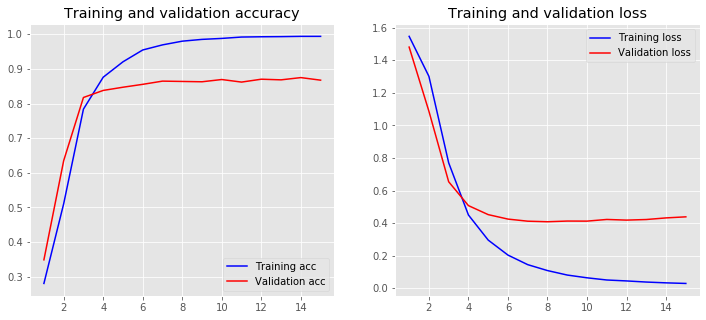

In [11]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

loss, accuracy = model.evaluate(X_train, 
                                Y_train, 
                                verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, 
                                Y_test, 
                                verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.8674698795180723
confusion matrix
 [[171  30   6   6   3]
 [ 12 186   9   7   2]
 [  6  13 182   0  14]
 [  2   7   6 200   1]
 [  2   3  13   1 197]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       216
           1       0.78      0.86      0.82       216
           2       0.84      0.85      0.84       215
           3       0.93      0.93      0.93       216
           4       0.91      0.91      0.91       216

    accuracy                           0.87      1079
   macro avg       0.87      0.87      0.87      1079
weighted avg       0.87      0.87      0.87      1079



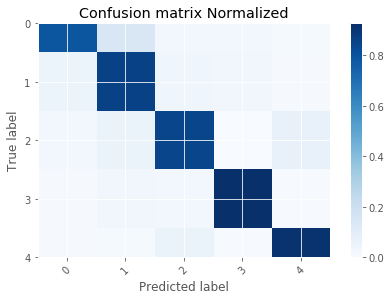

In [13]:
import numpy as np
from sklearn import metrics

Y_pred = model.predict(X_test, 
                       verbose=0)
evaluate_prediction(Y_pred.argmax(axis=1), 
                    Y_test.argmax(axis=1))

print(metrics.classification_report(Y_test.argmax(axis=1), 
                                    Y_pred.argmax(axis=1)))